### Multiscale Finite Element (MsFEM) in 2D
by Salih Kilicli

### Finite Element Method (FEM)

##### Strong Formulation:

$$- div(a(x) \nabla u(x)) = f(x) \quad \text{in}  \quad \Omega \subset R^d$$

$$(i) \quad u(x) = 0 \quad \text{on} \quad x \in \partial \Omega \quad \text{(Dirichlet BC)}$$

$$(ii)\quad \nabla u(x) = 0 \quad \text{on} \quad x \in \partial \Omega \quad \text{(Neumann BC)}$$

where $a(\mathbf{x}) = (a_{ij}(\mathbf{x}))$ is the conductivity tensor and is assumed to be symmetric and positive definite with upper and lower bounds. In the context of porous flows, this equation is the pressure equation for single phase steady flow through a porous medium, where by **Darcy's law**:  $\mathbf{q} = -\dfrac{\kappa}{\mu} \nabla u = - a \nabla u$.


##### Weak Formulation (Galerkin Method):

Multiplying the main equation by a test function $v(x)$ and applying the integration by parts (IBP) with given BC's one can easily show that the strong formulation is equivalent to the weak formulation of the problem below.

Find $u \in \ V$ such that:

$$a(u, \ v) = \int_{\Omega} a(x) \nabla u(x) \nabla v(x) dx = \int_{\Omega} f(x) v(x) dx = L(v)$$

for $\forall v \in V$, where $V = H_0^1(\Omega)$.

#### Galerkin dimension reduction

Now, choose a subspace $V_{h} := span\{\phi_0, \phi_1, \phi_2, \dots, \phi_n\} \subset V = H_0^1(\Omega)$ of finite dimension and solve the projected problem:

Find $u_h \in V_h$ such that:

$$a(u_h, \ v) = \int_{\Omega} a(x) \nabla u_h(x) \nabla v(x) dx = \int_{\Omega} f(x) v(x) dx = L(v)$$

for $\forall v \in V_h$, where $u_h(x) = \sum\limits_{i=1}^{n} u(x_i)\phi_i(x)$, and $ \ u(x_i) = u_i$ (dof). Moreover, $\phi_i(x_j) = \delta_{ij}$ and $\sum\limits_{i=1}^{n} \phi_i(x) =1$ (partition of unity).

#### Galerking orthogonality

The key property of the Galerkin approach is that the **error is orthogonal to the chosen subspaces**. Since $V_{h}\subset V$, we can use $u_{h}$ as a test vector in the original equation. Subtracting the two, we get the **Galerkin orthogonality** relation for the error, $\epsilon_{h}=u-u_{h}$ which is the error between the solution of the original problem, $u$, and the solution of the Galerkin equation, $u_{h}$.

$$a(u - u_h, \ v) = a(u, \ v) - a(u_h, \ v) = L(v) - L(v) = 0$$

### Multiscale Finite Element Method (MsFEM)

The method is designed to efficiently capture the large scale behavior of the solution without resolving all the small scale features. This is accomplished by constructing the multiscale finite element basis functions that are adaptive to the local property of the differential operator.

The central **goal of this approach** is to obtain the large scale solutions accurately and efficiently without resolving the small scale details. The main idea is to construct finite element basis functions capturing the small scale information within each element. The small scale information is then brought to the large scales through the coupling of the global stiffness matrix. Thus, the effect of small scales on the large scales is correctly captured.

#### Coarse-Fine Mesh Settings

For $0 < h \leq 1$, let $\mathcal{K}^h$ be a partition of $\Omega$ by a collection of rectangles $K$ with diameter $\leq h$. For each element $K \in \mathcal{K}^h$, we define a set of nodal basis $\{\phi_i^K\}_{i=1}^{n}$ with $n$ being the number of nodes of the element. The superscript $K$ will be neglected when bases in one element are considered. In the multiscale method, $\phi_i$ satisfies:

$$\nabla . \Big( a(\mathbf{x}) \nabla \phi_i \Big) = 0 \quad \text{in} \quad K \in \mathcal{K}^h$$

Note that, as usual, we require $\phi_i(x_j) = \delta_{ij}$ and one needs to specify the boundary condition (BC) of $\phi_i$ to make the problem above well-posed.

#### Mesh Parameters

$N_z \ (n_z)$ is the number of elements in each coarse (fine) direction. 

$H_z = \dfrac{1}{N_z} \ (h_z = \dfrac{1}{N_z * n_z})$ is the step size in each coarse (fine) direction. Here we assume $ \ \Omega = (0,1) \times (0,1)$, so $|\Omega| = 1$.

$l_z =N_z * n_z+1  \ (l_z-1 = N_z * n_z)$ is the number of total nodes (elements) in each direction where $z \in \{x, y\}$. 

The number of total nodes (elements) is given by $l_x * l_y \ ((l_x -1) * (l_y -1))$.

<div>
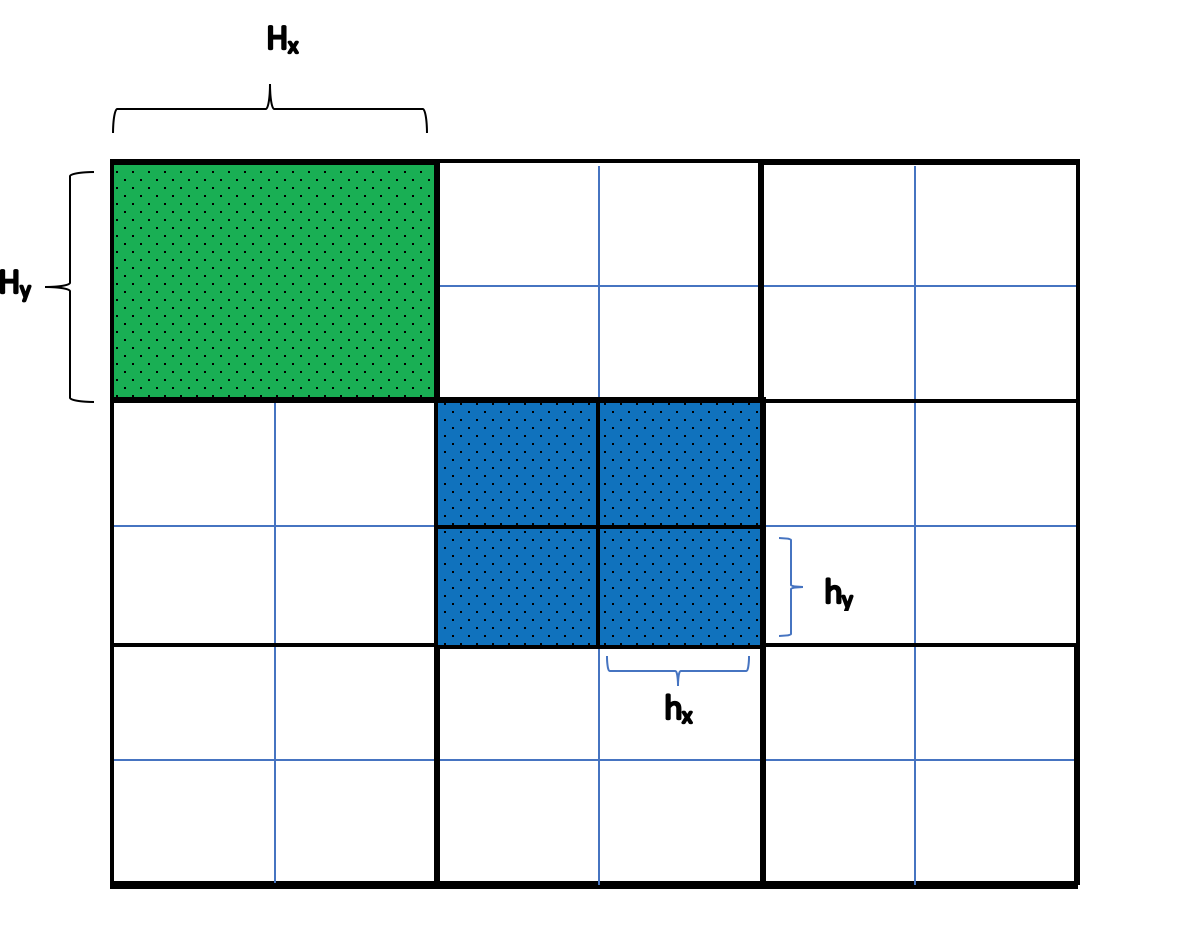
</div>

In the example above, **green** rectangle is called a *coarse mesh* element, whereas **blue** rectangles are *fine mesh* (4 of them) elements. 
    
Notice that, for the coarse mesh $N_x = N_y = 3 \Rightarrow H_x = H_y = 1/3$, for the fine mesh $n_x = n_y = 2 \Rightarrow h_x = h_y = 1/6$. 

The total number of nodes in each direction are given by $l_x, l_y = 7$, and the total number of nodes in the mesh is $l_x \times l_y = 49$.

### Bilinear Finite Element Method on Quadrilateral Elements (2D)

<div>
<img src="attachment:Quadliteral2D.png" width="600"/>
</div>

Assume the pyhsical element above is $K = (0, h_x) \times (0, h_y)$, and it consists of vertices $v_i = (x_i, y_i)$, where $\ v_1=(0, 0), \ v_2=(h_x, 0), \ v_3=(h_x, h_y)$, $v_4=(0, h_y)$. The reference (master) element is $\hat{K} = (-1, 1)^2$, and it consists of vertices $\ \hat{v_1}=(-1, -1), \ \hat{v_2}=(1, -1), \ \hat{v_3}=(1, 1), \ \hat{v_4}=(-1, 1)$. One can use a similar transformation in which $\hat{K} = (0,1)^2$ but we will prefer the first one since it is useful when we need to utilize Gaussian quadrature for approximating the integrals.

Bilinear basis functions yielding the transformation above are: $\hat{\phi_i}(\xi, \eta) = \frac{1}{4}(1 + \xi_o\xi)(1 + \eta_o\eta)$ where $\xi_o, \eta_o$ stands for the signs of the parameters at the point $\hat{v_i}=(\xi_i, \eta_i)$, that is (notice $N_i(\xi, \eta) = \hat{\phi_i}(\xi, \eta)$ in the figure):

$$\hat{\phi_1}(\xi, \eta) = \frac{1}{4}(1 - \xi)(1 - \eta)$$
$$\hat{\phi_2}(\xi, \eta) = \frac{1}{4}(1 + \xi)(1 - \eta)$$
$$\hat{\phi_3}(\xi, \eta) = \frac{1}{4}(1 + \xi)(1 + \eta)$$
$$\hat{\phi_4}(\xi, \eta) = \frac{1}{4}(1 - \xi)(1 + \eta)$$

Notice, that in this case, since $v_i=(0,0)$, we will have $x = h_x \xi, y = h_y \eta$. Therefore $|J|=\frac{|K|}{|\hat{K}|}=\frac{h_x h_y}{4}$ and $dxdy = dA =  |J| da = |J| d\xi d\eta$. Using this identity one can easily calculate the **element stiffness matrix** $A_{e}^1$, **element mass matrix** $A_{e}^0$ and the **element load vector** $F_{e}$ such as:

$$
A_{e}^1 = \dfrac{a_e^{11} h_y}{6h_x}
\begin{bmatrix}  
2      &-2     & -1     & 1 \\
\ddots & 2     &  1     & -1\\
\ddots &\ddots & 2      & -2\\
\ddots &\ddots &\ddots  & 2
\end{bmatrix} + \dfrac{a_e^{22} h_x}{6h_y} 
\begin{bmatrix}  
2      & 1     & -1    & -2 \\
\ddots & 2     & -2    & -1 \\
\ddots &\ddots & 2     &  1 \\
\ddots &\ddots &\ddots &  2
\end{bmatrix}, \quad \quad
A_{e}^0 = \dfrac{h_x h_y}{36}
\begin{bmatrix}  
4      & 2     & 1     & 2 \\
\ddots & 4     & 2     & 1 \\
\ddots &\ddots & 4     & 2 \\
\ddots &\ddots &\ddots & 4
\end{bmatrix}, \quad \quad F_e = \dfrac{h_x h_y f_e}{4}\begin{bmatrix}  
1 \\
1 \\
1 \\
1 
\end{bmatrix} \quad \quad
$$

where one needs to solve the matrix equation $\Big(a_e A_e^1 + A_e^0\Big) u_e = F_e$. Then, put these element matrices into a global (sparse) matrix to solve the original (fine) problem $Au = F$.

Let (upscaling operator) $R_{ij}=\Big[\phi^{w_i}(x_j)\Big] = \Big[\phi^{w_1}, \dots, \phi^{w_M}\Big] \in \mathcal{R}^{mxM}$ where $dim(\mathcal{V}_h)=m << M=dim(\mathcal{V}_H)$:

**Fine-scale problem**   $\quad : A_f u_h = b_f$, where $\ u_h \in \mathcal{R}^{mx1}$.

**Coarse-scale problem** $: A_c u_c = b_c \ $, where $\ u_c \in \mathcal{R}^{Mx1}$, $\ A_c = R^{T} \ A_f \ R $, and $\ b_c = R^{T} \ b_f$. 

**Multi-scale solution** $\quad : u_H = R \ u_c$, where $u_H \in \mathcal{R}^{mx1}$. Finally, compare the solutions if $u_H \approx u_h$.

In [1]:
# Importing necessary libraries

from time import time
from scipy.interpolate import griddata
from scipy.sparse import csr_matrix, csc_matrix, coo_matrix, dok_matrix, lil_matrix, identity, diags
from scipy.sparse.linalg import spsolve #, lsqr, lsmr, 
import scipy as sp
import numpy as np
from numpy import pi, exp
np.set_printoptions(linewidth=150, precision=15, floatmode='maxprec', legacy='1.13')
import pandas as pd
pd.set_option('precision', 15)
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
%matplotlib inline

In [3]:
# Options for Visualization

enumerate_index         = False;
visualize_medium        = True;
visualize_fine_solution = True;
visualize_ms_solution   = True;

# Option for offline - online stage (True online, False offline)

compute_ms_basis        = True;

In [4]:
# Mesh Settings
eps = np.spacing(1)

# Coarse partition
Nx, Ny = 10, 11
Hx, Hy = 1/Nx, 1/Ny

# Fine partition
nx, ny = 12, 13
hx, hy = Hx/nx, Hy/ny

# Number of nodes in each direction lx, ly # Number of total Nodes: lx*ly
lx = Nx*nx+1
ly = Ny*ny+1

#### Permeability Field

In [5]:
# Problem setup

# Loading Permeability field
df = pd.read_csv("permeability.txt", header=None)
kappa = df.to_numpy().reshape(df.shape, order='F')
kappa = np.ones(df.shape)

# Source term
f = lambda x, y: x**4 + y**4
#f = lambda x, y: 1 + 0*x*y
#f = lambda x, y: (2*pi**2)*sin(pi*x)*cos(pi*y)

# Boundary Conditions (BC) for the source term
f0= lambda x, y: 0*x*y

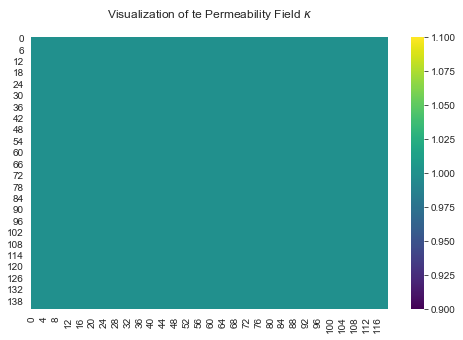

In [6]:
# Visualization of the Mesh Grid nodes
if enumerate_index and visualize_medium:
    fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 5))
else:
    fig, ax2 = plt.subplots(nrows=1, ncols=1, figsize=(8, 5))

if enumerate_index:
    (X, Y) = np.meshgrid(np.linspace(0, 1, lx), np.linspace(0, 1, ly))
    X = X.flatten(order ='F')
    Y = Y.flatten(order ='F')
    Z = np.arange(1, ly*lx+1)#.reshape((-1, 1), order='F')
    for i in range(X.shape[0]):
        ax1.text(X[i], Y[i], str(Z[i]), fontsize=12) # bbox=dict(facecolor='grey', alpha=0.85))
        ax1.axis('off')      
    ax1.set_title('Visualization of the Mesh Grid Nodes\n\n')
    
# Visualization of the Permeability field
(m, n) = kappa.shape
(hx_a, hy_a) = 1/m, 1/n
(X_a, Y_a) = np.meshgrid(np.arange(hx_a/2, 1, hx_a), np.arange(hy_a/2, 1, hy_a))
(X, Y) = np.meshgrid(np.arange(hx/2, 1, hx), np.arange(hy/2, 1, hy))
points = np.hstack((X_a.reshape((-1, 1), order='F'), Y_a.reshape((-1, 1), order='F')))
pfield = griddata(points, kappa.flatten(order ='F'), (X, Y), method='nearest')

if visualize_medium:
    sns.heatmap(pfield, cmap='viridis')
    #plt.imshow(pfield, cmap='viridis', interpolation='nearest')
    ax2.set_title('Visualization of te Permeability Field $\kappa$ \n')

In [7]:
# Forming the Global Stiffness, Mass Matrices

def finematrix_2d(pfield, Nx, Ny, nx, ny):
    (ratiox, ratioy) = (hy/hx, hx/hy)
    
    #            boundary1
    #              ------
    #  boundary3  |  K  | boundary4
    #             ------
    #           boundary2
    
    idx = np.arange(ly*lx).reshape((ly, lx), order='F')
    bdry1 = idx[0, :]      # First row (bdry1)
    bdry2 = idx[-1, :]     # Last row  (bdry2)
    bdry3 = idx[1:-1, 0]   # bdry3
    bdry4 = idx[1:-1,-1]   # bdry4
    boundary = np.hstack((bdry1, bdry2, bdry3, bdry4))
    
    idx1 = idx[0:-1, 0:-1].flatten(order='F') # array vs vector .reshape((-1, 1), order='F')
    idx2 = (idx1 + ly).flatten(order='F')
    idx3 = (idx1 + 1).flatten(order='F')
    idx4 = (idx1 + 1 + ly).flatten(order='F')
    
    lst1 = np.array([2, -2, 1, -1, -2, 2, -1, 1, 1, -1, 2, -2, -1, 1, -2, 2]).reshape(-1, 1)
    lst2 = np.array([2, 1, -2, -1, 1, 2, -1, -2, -2, -1, 2, 1, -1, -2, 1, 2]).reshape(-1, 1)
    data1= np.kron(lst1*ratiox + lst2*ratioy, pfield.reshape((-1, 1), order='F'))/6
    lst3 = np.array([1/9,1/18,1/18,1/36, 1/18,1/9,1/36,1/18, 1/18,1/36,1/9,1/18, 1/36,1/18,1/18,1/9]).reshape(-1,1)
    data2= np.kron(lst3, np.ones((pfield.size, 1)))*(hx*hy)
    row_ind = np.tile(np.vstack((idx1, idx2, idx3, idx4)), (4,1))
    col_ind = np.vstack((np.tile(idx1, (4,1)), np.tile(idx2, (4,1)), np.tile(idx3, (4,1)), np.tile(idx4, (4,1))))
    
    Global_DA = csr_matrix((data1.reshape(-1), (row_ind.reshape(-1), col_ind.reshape(-1)))) #Global Stiffness 
    Global_DA.eliminate_zeros()
    
    Global_M  = csr_matrix((data2.reshape(-1), (row_ind.reshape(-1), col_ind.reshape(-1)))) #Global Mass
    Global_M.eliminate_zeros()
    return Global_DA, Global_M, boundary

In [8]:
# Forming the Global load vector

def form_source(f, Nx, Ny, nx, ny):
    idx = np.arange(ly*lx).reshape((ly, lx), order='F')
    
    idx1 = idx[0:-1, 0:-1].flatten(order='F') # same with .reshape((-1, 1), order='F') #rowwise  'F', colwise 'C'
    idx2 = (idx1 + ly).flatten(order='F')
    idx3 = (idx1 + 1).flatten(order='F')
    idx4 = (idx1 + 1 + ly).flatten(order='F')
    
    data= hx*hy*np.kron(np.ones((4,1)), f.flatten(order='F'))/4
    row_ind = np.vstack((idx1, idx2, idx3, idx4))
    col_ind = np.zeros((4*Nx*nx*Ny*ny, 1),  dtype=int)
    
    F = csr_matrix((data.reshape(-1), (row_ind.reshape(-1), col_ind.reshape(-1))))
    F.eliminate_zeros()
    return F

### Fine-scale Matrix system

#### Homogeneous Neumann problem (includes the boundary nodes)

- Global_DA  := Global (fine) stiffness matrix
- Global_M   := Global (fine) mass matrix
- Global_F   := Global (fine) load vector
- bdry_idx   := boundary index of dofs in global numbering

#### Dirichlet problem (excludes the boundary nodes)

- fine_DA    := fine-scale stiffness matrix
- fine_M     := fine-scale mass matrix
- fine_RHS   := fine-scale load vector
- inter_idx  := index of interior dofs in global numbering


In [9]:
# Fine Scale Matrix System

# Homogeneous Neumann Problem
(Global_DA, Global_M, bdry_idx) = finematrix_2d(pfield, Nx, Ny, nx, ny)
(X, Y) = np.meshgrid(np.arange(hx/2, 1, hx), np.arange(hy/2, 1, hy))
Global_F = form_source(f(X, Y), Nx, Ny, nx, ny)

# Dirichlet Problem - Imposing Boundary Conditions
inter_idx = np.arange(lx*ly)
inter_idx = np.delete(inter_idx, bdry_idx) #deletes boundary indices

fine_DA   = Global_DA[inter_idx, :][:, inter_idx].copy()   # csr_matrix.A = csr_matrix.todense()
fine_M    = Global_M[inter_idx, :][:, inter_idx].copy()    # csr_matrix.A[r, c] slicing is much faster
fine_F    = Global_F[inter_idx].copy()                     # csr_matrix[r, ] row slicing is much faster

(X, Y) = np.meshgrid(np.linspace(0, 1, lx), np.linspace(0, 1, ly))
bfc    = f0(X, Y)
bfc[1:-1, 1:-1] = 0                                 # interior elemens of BC vector is set to zero
fine_bF = -Global_DA[inter_idx-1] @ bfc.reshape((-1, 1), order='F') #np.matmul(A, B) = A@B

fine_RHS = fine_F + fine_bF

Fine problem is solved in: 0.141286 seconds


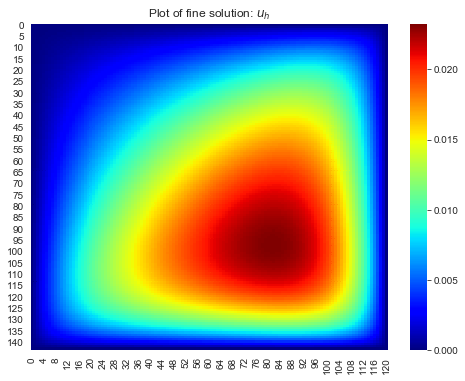

In [10]:
# Fine Solution and Visualization
start = time()
fine_U = spsolve(fine_DA, fine_RHS, use_umfpack=True)
print(f"Fine problem is solved in: {time() - start:4.6f} seconds")

plt.figure(figsize=(8, 6))
if visualize_fine_solution:
    plot_fine = bfc.copy()
    plot_fine[1:-1, 1:-1] = fine_U.reshape((Ny*ny-1, Nx*nx-1), order='F')
    sns.heatmap(plot_fine, cmap='jet')
    plt.title('Plot of fine solution: $u_{h}$') 

In [11]:
def MsFEM_2d_basis(Global_DA, Nx, Ny, nx, ny):
    loc_basis = np.zeros((lx*ly, (Nx+1)*(Ny+1))) # lz = Nz*nz+1 for z in {x, y}
    F = np.zeros(((nx+1)*(ny+1), 4))
    loc_boundary1 = np.arange(0, (ny+1)*(nx+1), ny+1)                 
    loc_boundary2 = np.arange(ny, (ny+1)*(nx+1), ny+1)          
    loc_boundary3 = np.arange(1, ny)
    loc_boundary4 = np.arange(nx*(ny+1)+1, (ny+1)*(nx+1)-1)
    loc_boundary = np.hstack((loc_boundary1, loc_boundary2, loc_boundary3, loc_boundary4))
    
    (loc_X, loc_Y) = np.meshgrid(np.linspace(0, 1, nx+1), np.linspace(0, 1, ny+1))
    # X.T.flat is same with X.flatten.reshape((-1, 1), order='F') or X.respahe((-1,1), order='F')
    # X.flat gives the flattened matrix in 'C' format, while X.T.flat is in 'F' format
    
    F[loc_boundary, 0] = (1-loc_X.T.flat[loc_boundary])*(1-loc_Y.T.flat[loc_boundary])
    F[loc_boundary, 1] = (1-loc_X.T.flat[loc_boundary])*(  loc_Y.T.flat[loc_boundary])
    F[loc_boundary, 2] = (  loc_X.T.flat[loc_boundary])*(1-loc_Y.T.flat[loc_boundary])
    F[loc_boundary, 3] = (  loc_X.T.flat[loc_boundary])*(  loc_Y.T.flat[loc_boundary])
    
    idx = np.arange(lx*ly).reshape(ly, lx, order='F')
    for i in np.arange(Nx):
        for j in np.arange(Ny):
            loc_idx = idx[np.ix_(j*ny + np.arange(ny+1), i*nx + np.arange(nx+1))] #np.ix_ for submatrices
            #loc_idx = loc_idx.reshape(-1, order='F')       #loc_idx.T.flat is the same but is an iterator
            loc_A = Global_DA.todense()[np.ix_(loc_idx.T.flat, loc_idx.T.flat)]
            loc_A[loc_boundary, :] = 0
            ##loc_A[loc_boundary, loc_boundary] = identity(2(ny+nx)) #sparse identity matrix
            loc_A.flat[loc_boundary+ loc_boundary*loc_A.shape[0]] = 1
            loc_basis[np.ix_(loc_idx.T.flat, [i*(Ny+1)+j, i*(Ny+1)+j+1, (i+1)*(Ny+1)+j, (i+1)*(Ny+1)+j+1])] = \
            spsolve(csr_matrix(loc_A), F, use_umfpack=True)           
    return loc_basis

In [12]:
#Offline-Online Multiscale Basis Functions

if compute_ms_basis:
    MS_basis = MsFEM_2d_basis(Global_DA, Nx, Ny, nx, ny)
    np.savetxt('MS_basis.csv', MS_basis)
else:
    np.loadtxt('MS_basis.csv')

### Multiscale Matrix System

In [13]:
# Multiscale Matrix System
start = time()
MS_basis = MsFEM_2d_basis(Global_DA, Nx, Ny, nx, ny)
print(f"Multiscale basis is computed in: {time() - start:4.6f} seconds")

inter_idx_coarse = np.arange((Nx+1)*(Ny+1))
bdry1 = np.arange(0, (Nx+1)*(Ny+1), Ny+1)
bdry2 = np.arange(Ny,(Nx+1)*(Ny+1), Ny+1)
bdry3 = np.arange(1, Ny)
bdry4 = (Ny+1)*Nx + np.arange(1, Ny)
bdry_coarse = np.hstack((bdry1, bdry2, bdry3, bdry4)).flatten()
inter_idx_coarse = np.delete(inter_idx_coarse, bdry_coarse)

ms_basis = MS_basis[inter_idx, :]
ms_DA    = ms_basis.T @ fine_DA @ ms_basis
ms_M     = ms_basis.T @ fine_M @ ms_basis
ms_F     = ms_basis.T @ fine_F

(X, Y) = np.meshgrid(np.linspace(0, 1, Nx+1), np.linspace(0, 1, Ny+1))
ms_bfc = f0(X, Y)
ms_bfc[1:-1, 1:-1] = 0
ms_bF = -ms_DA.T @ ms_bfc.reshape((-1, 1), order='F')
ms_RHS = ms_F + ms_bF

ms_DA = ms_DA[inter_idx_coarse, :][:, inter_idx_coarse]
ms_M  = ms_M[inter_idx_coarse, :][:, inter_idx_coarse]
ms_basis = ms_basis[:, inter_idx_coarse]
ms_RHS = ms_RHS[inter_idx_coarse]

Multiscale basis is computed in: 8.352102 seconds


Coarse problem is solved in: 0.001707 seconds


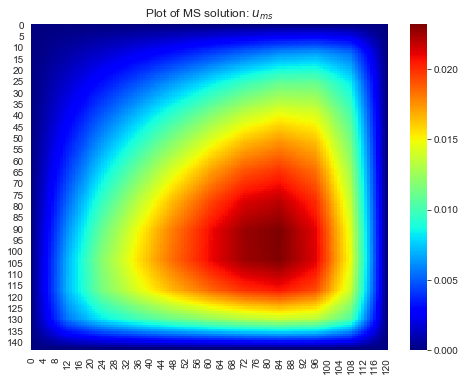

In [14]:
# MsFEM Solution and Visualization

start = time()
ms_U = spsolve(csr_matrix(ms_DA), ms_RHS, use_umfpack=True)
print(f"Coarse problem is solved in: {time() - start:4.6f} seconds")

ms_U_fine = ms_basis @ ms_U

plt.figure(figsize=(8, 6))
if visualize_ms_solution:
    plot_ms = bfc
    plot_ms[1:-1, 1:-1] = ms_U_fine.reshape((Ny*ny-1, Nx*nx-1), order='F')
    sns.heatmap(plot_ms, cmap='jet')
    plt.title('Plot of MS solution: $u_{ms}$') 

#### Comparison of  the Multiscale and Fine Solutions: $ \ u_H \approx u_h$

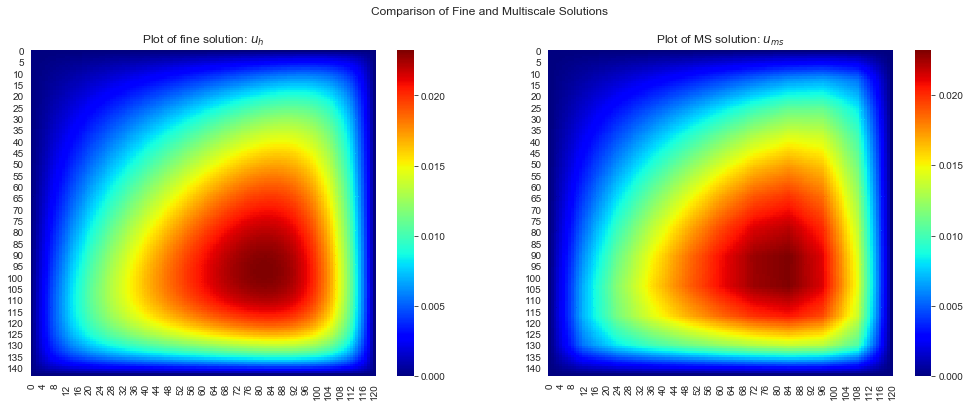

In [15]:
fig, (ax1, ax2) = plt.subplots(nrows=1, ncols=2, figsize=(17, 6))
fig.suptitle('Comparison of Fine and Multiscale Solutions')

if visualize_fine_solution:
    plot_fine = bfc
    plot_fine[1:-1, 1:-1] = fine_U.reshape((ly-2, lx-2), order='F')
    sns.heatmap(plot_fine, cmap='jet', ax=ax1)
    ax1.set_title('Plot of fine solution: $u_h$')
    
if visualize_ms_solution:
    plot_ms = bfc
    plot_ms[1:-1, 1:-1] = ms_U_fine.reshape((ly-2, lx-2), order='F') #lz = (Nz*nz+1) including boundary
    sns.heatmap(plot_ms, cmap='jet', ax=ax2)
    ax2.set_title('Plot of MS solution: $u_{ms}$')

In [17]:
# If you would like to compare the u_h (fine solution) and u_H (multiscale solution):
(uh, uH) = (fine_U.reshape(-1), ms_U_fine.reshape(-1))
names = ('Fine Solution - $u_h$ ', 'Multiscale Solution - $u_H$', 'Difference: |$u_h - u_H$|')
df = pd.DataFrame(zip(uh, uH, np.abs(uh-uH)), columns = names, index=None)
df.head(10)

,Fine Solution - $u_h$,Multiscale Solution - $u_H$,Difference: |$u_h - u_H$|
0,0.000005217127211,0.000005194737947,0.000000022389263
1,0.000010434255715,0.000010389475895,0.000000044779820
2,0.000015651400545,0.000015584213842,0.000000067186703
3,0.000020868600680,0.000020778951790,0.000000089648890
4,0.000026085926908,0.000025973689737,0.000000112237171
5,0.000031303488221,0.000031168427685,0.000000135060536
6,0.000036521437127,0.000036363165632,0.000000158271495
7,0.000041739974101,0.000041557903579,0.000000182070522
8,0.000046959351321,0.000046752641527,0.000000206709794
9,0.000052179875794,0.000051947379474,0.000000232496319


#### Error Analysis - Calculating Relative Errors

In [19]:
U_ms = ms_U_fine.reshape((-1, 1), order='F')
U_h  = fine_U.reshape((-1, 1), order='F')

DG_error = ((U_ms - U_h).T @ fine_DA @ (U_ms - U_h))/(U_h.T @ fine_DA @ U_h)
L2_error = ((U_ms - U_h).T @ fine_M  @ (U_ms - U_h))/(U_h.T @ fine_M @ U_h)

print(f'The relative Energy Error for MsFEM: \t {np.sqrt(*DG_error[0])*100:5.2f}')
print(f'The relative   L2   Error for MsFEM: \t {np.sqrt(*L2_error[0])*100:5.2f}')

The relative Energy Error for MsFEM: 	 20.22
The relative   L2   Error for MsFEM: 	  2.95


### Important notes for computational time

<font color=red>**Note: Code works perfectly, it just needs to be optimized for larger $l_x$, $l_y$ values. Slicing spicy.csr_matrix( ) seems to be very slow.**<font>
    

<font color=black>**Solution:** Let M be a csr_matrix():
    
(i) M[row, :][:, col] is fastest but it doesn't work for assignments   
(ii) M.A[ row, col ] is faster for full slicing, M[ row, : ] is faster for row slicing   
(iii) M[ row ][ : , col ] is faster than M[ row, col ] and M[ row ].tocsc( )[ : , col]<font>
    

#### Difference Between reshape, flatten, flat, ravel

In [ ]:
A = np.arange(10).reshape(-1, 1)
print(f'A = {A.shape}, {A.ndim} \n {A}')
B = np.arange(10).flatten(order='F').reshape(-1, 1)
print(f'B = {B.shape}, {B.ndim} \n{B}')
C = np.arange(10)
print(f'C = {C.shape}, {C.ndim} \n{C}')
D = np.arange(10).flat
print(f'D = Iteritem, nodim \n{list(D)}')
E = np.arange(10).ravel()
print(f'E = {E.shape}, {E.ndim} \n{E}')